In [32]:
from sympy import *
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import os
import pandas as pd
import fenics as fe
import dill

In [33]:
# Test Parameter
ConstitutiveModels = ['NeoHookean', 'MooneyRivlin', 'Gent', 'Demiray', 'Ogden']
ConstitutiveModel  = ConstitutiveModels[4]   # Constitutive model
StretchRange  = [0.1, 5]                   # Stretch ratio interval
DeltaStretch  =  0.01                        # Step size

# Material Parameters
LambdaV =  1E6   # 1st Lamé parameter
MuV     =  660   # 2nd Lamé parameter (Shear modulus) (Pa)

C01V    =  0.00  # Mooney-Rivlin 3rd material constant (Pa) if == 0 => Neo-Hookean
JmV     =  0.08  # Gent 3rd material constant (-) if == 1 => ~Neo-Hookean with ln
BetaV   =  20.3  # Demiray 3rd material constant (-) if == 1 => ~Neo-Hookean with exp
AlphaV  = -24.3  # Ogden 3rd material constant (-) if == 2 => Neo-Hookean

# Folder for the results
Output_Path = os.path.join('Results')
os.makedirs(Output_Path, exist_ok=True)
FileName = ConstitutiveModel + '_Lambda' + str(LambdaV) + '_Mu' + str(MuV)

In [34]:
# Symbolic material parameters
Lambda, Mu   = symbols(r'\lambda \mu', positive=True)

# Identity tensor
I = eye(3)

# Direction vectors
e1 = I[:,0]
e2 = I[:,1]
e3 = I[:,2]

# Dilatation coefficients
LambdaH = 1                                      # Coefficient for homogeneous dilatation
LambdaX = symbols(r'\lambda_x', positive=True)   # Coefficient for lengthening in e1 direction (here <1)
LambdaY = symbols(r'\lambda_y', positive=True)   # Coefficient for lengthening in e2 direction (here <1)
LambdaZ = symbols(r'\lambda_z', positive=True)   # Coefficient for lengthening in e3 direction (here >1)

# Uniaxial tension
LambdaX = LambdaZ**Rational(-1/2)
LambdaY = LambdaX

# Deformation matrices
U = I + (LambdaX-1) * np.outer(e1,e1) + (LambdaY-1) * np.outer(e2,e2) + (LambdaZ-1) * np.outer(e3,e3)

# Gradient of the deformation
F = (LambdaH-1) * I + U

# Volume change
J = det(F)

# Right Cauchy-Green strain tensor
C = transpose(F) * F

# Eigenvalues of Right Cauchy-Green strain tensor
Lambda1, Lambda2, Lambda3 = symbols(r'\lambda_1 \lambda_2 \lambda_3')

# Invariants
J, I1, I2 = symbols(r'J I_1 I_2')
JFunction = Lambda1*Lambda2*Lambda3
I1Function = Lambda1**2+Lambda2**2+Lambda3**2
I2Function = Lambda1**2*Lambda2**2 + Lambda2**2*Lambda3**2 + Lambda3**2*Lambda1**2

# Hyperelastic models (incompressible)
if ConstitutiveModel == ConstitutiveModels[0]:     # Neo-Hookean
    C1           = symbols(r'C_1', positive=True)
    C1Function   = Mu / 2
    Psi          = C1 * (I1 - 3)
    
elif ConstitutiveModel == ConstitutiveModels[1]:   # Mooney-Rivlin
    C01, C10, D1 = symbols(r'C_{01} C_{10} D_{1}', positive=True)
    C10Function  = Mu / 2 - C01
    D1Function   = (Lambda + 2*Mu/3) / 2
    Psi          = C01 * (J**Rational(-4,3)*I2 - 3) + C10 * (J**Rational(-2,3)*I1 - 3)

elif ConstitutiveModel == ConstitutiveModels[2]:   # Gent
    Jm           = symbols('J_m')
    Psi          = - Mu*Jm/2 * ln(1 - (I1 - 3) / Jm)

elif ConstitutiveModel == ConstitutiveModels[3]:   # Demiray
    Beta         = symbols(r'\beta')
    Psi          = Mu/2 * (exp(Beta*(I1 - 3)) - 1) / Beta

elif ConstitutiveModel == ConstitutiveModels[4]:   # Ogden
    Alpha        = symbols(r'\alpha')
    Psi          = 2*Mu * (Lambda1**Alpha + Lambda2**Alpha + Lambda3**Alpha - 3) / Alpha**2
    
# Derivative with respect to Lambdas (https://en.wikipedia.org/wiki/Hyperelastic_material: compressible isotropic hyperelastic material)
PsiLambda = Psi.subs({J:JFunction,I1:I1Function,I2:I2Function})

T1 = Lambda1*Derivative(PsiLambda, Lambda1)
T1 = T1.doit()

T2 = Lambda2*Derivative(PsiLambda, Lambda2)
T2 = T2.doit()

T3 = Lambda3*Derivative(PsiLambda, Lambda3)
T3 = T3.doit()

T = T1 * np.outer(e1,e1) + T2 *np.outer(e2,e2) + T3 * np.outer(e3,e3)
T = Matrix(T).doit()
T = T.subs({JFunction:J,I1Function:I1,I2Function:I2})
T = simplify(T)
T = T.subs({JFunction:J,I1Function:I1,I2Function:I2})
T = T.subs({J:'J',I1:'I_1',I2:'I_2'})

# Replace invariants
T = T.subs({'J':JFunction,'I_1':I1Function,'I_2':I2Function})

# Replace material constants
if ConstitutiveModel == ConstitutiveModels[0]:       # Neo-Hookean
    T = T.subs({C1:C1Function})
elif ConstitutiveModel == ConstitutiveModels[1]:     # Mooney-Rivlin
    T = T.subs({C10:C10Function})

# Replace eingenvalues
Lambdas = C.eigenvals()
Lambdas = list(Lambdas)
T = T.subs({Lambda1:sqrt(Lambdas[0]), Lambda2:sqrt(Lambdas[0]), Lambda3:sqrt(Lambdas[1])})

# T11 and T22 are null
T = T - T[0,0] * I
T = simplify(T)

# Other stresses
J = det(F)                                    # Volume change
P = J * T * F.inv().transpose()               # Nominal stress
S = J * F.inv() * T * F.inv().transpose()     # Material stress

# Compute axial stress
StretchSteps = np.arange(StretchRange[0],StretchRange[1],DeltaStretch)

if ConstitutiveModel == ConstitutiveModels[0]:                            # Neo-Hookean
    AnalyticalFunction = lambdify((Lambda, Mu, LambdaZ), P[2,2], 'numpy')
    AnalyticalStress   = AnalyticalFunction(LambdaV, MuV, StretchSteps)
    
elif ConstitutiveModel == ConstitutiveModels[1]:                          # Mooney-Rivlin
    AnalyticalFunction = lambdify((C01, Lambda, Mu, LambdaZ), P[2,2], 'numpy')
    AnalyticalStress   = AnalyticalFunction(C01V, LambdaV, MuV, StretchSteps)
    FileName = FileName + '_C01' + str(C01V)
    
elif ConstitutiveModel == ConstitutiveModels[2]:                          # Gent
    AnalyticalFunction = lambdify((Jm, Lambda, Mu, LambdaZ), P[2,2], 'numpy')
    AnalyticalStress   = AnalyticalFunction(JmV, LambdaV, MuV, StretchSteps)
    FileName = FileName + '_Jm' + str(JmV)
    
elif ConstitutiveModel == ConstitutiveModels[3]:                          # Demiray
    AnalyticalFunction = lambdify((Beta, Lambda, Mu, LambdaZ), P[2,2], 'numpy')
    AnalyticalStress   = AnalyticalFunction(BetaV, LambdaV, MuV, StretchSteps)
    FileName = FileName + '_Beta' + str(BetaV)
    
elif ConstitutiveModel == ConstitutiveModels[4]:                          # Ogden
    AnalyticalFunction = lambdify((Alpha, Lambda, Mu, LambdaZ), P[2,2], 'numpy')
    AnalyticalStress   = AnalyticalFunction(AlphaV, LambdaV, MuV, StretchSteps)
    FileName = FileName + '_Alpha' + str(AlphaV)

# Save values to table
DataFrame = pd.DataFrame({'Stretch Ratio (-)':StretchSteps, 'Analytical Stress (Pa)':AnalyticalStress})
DataFrame.to_csv(os.path.join(Output_Path, FileName + '.csv'), index=False)

In [38]:
# Save function
dill.settings['recurse'] = True
dill.dump(AnalyticalFunction, open(os.path.join(Output_Path,ConstitutiveModel + 'UniaxialLoading'), 'wb'))

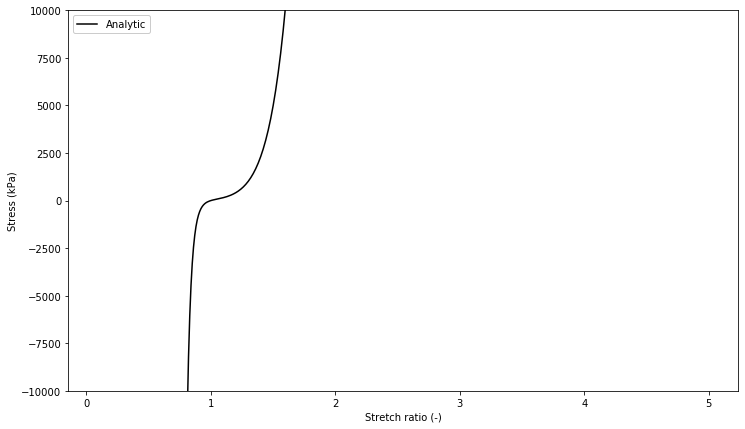

In [36]:
# Plot Results
plt.figure(figsize=(12,7))
ax = plt.subplot(1, 1, 1)
DataFrame.plot(x='Stretch Ratio (-)', y='Analytical Stress (Pa)', ax=ax, color = 'black', linestyle = '-', label='Analytic')
ax.set_xlabel('Stretch ratio (-)')
ax.set_ylabel('Stress (kPa)')
ax.set_ylim([-10000,10000])
plt.legend(loc='upper left', frameon=True, framealpha=1)
plt.savefig(os.path.join(Output_Path, FileName + '.pdf'))
plt.show()